# Topic
Making a forecasting model with FB Prophet<br>
[Link to Dataset](https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting)

In [220]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

# Data Preparation

Preparing the data for forecasting.
* Taking order date as date column 
* Sales is the label
* Removing outliers
* Aggregating the dataframe on date column.

In [221]:
df = pd.read_csv('superstore_sales.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [222]:
df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [224]:
df['ds'] = pd.to_datetime(df.loc[:, 'Order Date'], format = "%d/%m/%Y").dt.date
df['ds'] = pd.to_datetime(df['ds'])

In [225]:
df = df.loc[:, ['ds', 'Sales']]
df.head()

,ds,Sales
0,2017-11-08,261.9600
1,2017-11-08,731.9400
2,2017-06-12,14.6200
3,2016-10-11,957.5775
4,2016-10-11,22.3680


In [226]:
df.ds.apply(lambda x: x.year).unique()

array([2017, 2016, 2015, 2018])

In [227]:
df_copy = df.copy()

In [228]:
df.rename(columns = {'Sales': 'y'}, inplace = True)
df.head()

,ds,y
0,2017-11-08,261.9600
1,2017-11-08,731.9400
2,2017-06-12,14.6200
3,2016-10-11,957.5775
4,2016-10-11,22.3680


In [229]:
df

,ds,y
0,2017-11-08,261.9600
1,2017-11-08,731.9400
2,2017-06-12,14.6200
3,2016-10-11,957.5775
4,2016-10-11,22.3680
...,...,...
9795,2017-05-21,3.7980
9796,2016-01-12,10.3680
9797,2016-01-12,235.1880
9798,2016-01-12,26.3760


## Removing outliers

In [230]:
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the DataFrame
df_no_outliers = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)]
df_no_outliers

,ds,y
0,2017-11-08,261.960
2,2017-06-12,14.620
4,2016-10-11,22.368
5,2015-06-09,48.860
6,2015-06-09,7.280
...,...,...
9795,2017-05-21,3.798
9796,2016-01-12,10.368
9797,2016-01-12,235.188
9798,2016-01-12,26.376


In [231]:
df = df_no_outliers.copy()

In [232]:
df = df.groupby('ds').agg({'y': 'sum'})

In [233]:
df = df.reset_index()
df

,ds,y
0,2015-01-03,16.4480
1,2015-01-04,288.0600
2,2015-01-05,19.5360
3,2015-01-06,467.3400
4,2015-01-07,87.1580
...,...,...
1212,2018-12-26,63.9140
1213,2018-12-27,177.6360
1214,2018-12-28,931.5108
1215,2018-12-29,1707.6940


# Adding holiday columns

In [234]:
holidays_dict = {
    "Thanksgiving": ["11-26-2015", "11-24-2016", "11-23-2017", "11-22-2018"],
    "Black Friday": ["11-27-2015", "11-25-2016", "11-24-2017", "11-23-2018"],
    "Christmas": ["12-25-2015", "12-25-2016", "12-25-2017", "12-25-2018"],
    "Easter": ["04-05-2015", "03-27-2016", "04-16-2017", "04-01-2018"]
}

In [235]:
# Add a column for each federal holiday and set the value to 1 for that holiday's date
for holiday, dates in holidays_dict.items():
    for date in dates:
        df.loc[df['ds'] == date, holiday] = 1

# Fill in any missing holiday values with 0
df = df.fillna(0)

In [236]:
columns = ['Thanksgiving', 'Black Friday', 'Christmas', 'Easter']
df[columns] = df[columns].astype(int)
df.head()

,ds,y,Thanksgiving,Black Friday,Christmas,Easter
0,2015-01-03,16.448,0,0,0,0
1,2015-01-04,288.060,0,0,0,0
2,2015-01-05,19.536,0,0,0,0
3,2015-01-06,467.340,0,0,0,0
4,2015-01-07,87.158,0,0,0,0


# EDA

In [237]:
df.describe()

,ds,y,Thanksgiving,Black Friday,Christmas,Easter
count,1217,1217.000000,1217.000000,1217.000000,1217.000000,1217.000000
mean,2017-01-23 00:53:14.741166592,662.909918,0.003287,0.003287,0.002465,0.003287
min,2015-01-03 00:00:00,1.964000,0.000000,0.000000,0.000000,0.000000
25%,2016-01-12 00:00:00,204.540000,0.000000,0.000000,0.000000,0.000000
50%,2017-02-06 00:00:00,501.186000,0.000000,0.000000,0.000000,0.000000
75%,2018-01-23 00:00:00,948.538000,0.000000,0.000000,0.000000,0.000000
max,2018-12-30 00:00:00,4180.164000,1.000000,1.000000,1.000000,1.000000
std,NaN,584.760142,0.057260,0.057260,0.049609,0.057260


In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            1217 non-null   datetime64[ns]
 1   y             1217 non-null   float64       
 2   Thanksgiving  1217 non-null   int64         
 3   Black Friday  1217 non-null   int64         
 4   Christmas     1217 non-null   int64         
 5   Easter        1217 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 57.2 KB


<Axes: >

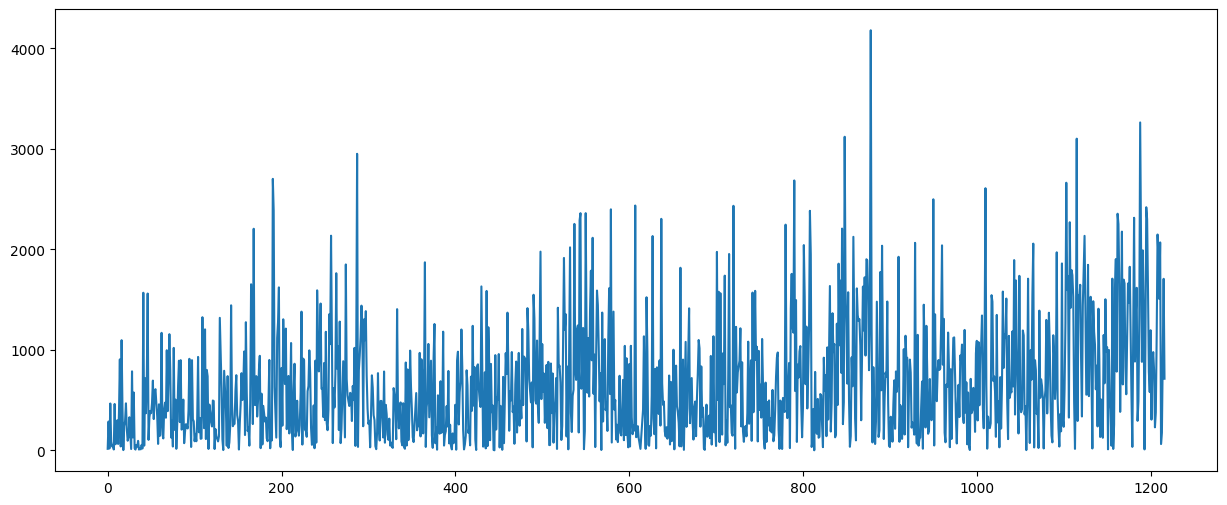

In [239]:
df.y.plot(figsize = (15,6))

In [240]:
df.sort_values(by = 'y',
              ascending = False)

,ds,y,Thanksgiving,Black Friday,Christmas,Easter
878,2017-12-11,4180.164,0,0,0,0
1188,2018-12-01,3263.148,0,0,0,0
848,2017-11-10,3120.788,0,0,0,0
1115,2018-09-15,3101.738,0,0,0,0
287,2015-12-20,2951.110,0,0,0,0
...,...,...,...,...,...,...
133,2015-06-24,4.272,0,0,0,0
18,2015-01-28,3.928,0,0,0,0
1057,2018-07-12,3.816,0,0,0,0
445,2016-07-19,2.025,0,0,0,0


# Dynamic Holidays

In [241]:
# Easter
easter_dates = df[df.Easter ==1 ].ds
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': easter_dates,
                       'lower_window': -5,
                       'upper_window': 2})

In [242]:
# Black Friday
bf_dates = pd.to_datetime(df[df['Black Friday'] == 1].ds)
bf = pd.DataFrame({'holiday': 'black_friday',
                   'ds': bf_dates,
                   'lower_window': -3,
                   'upper_window': 2})

In [243]:
# Thanksgiving
tg_dates = pd.to_datetime(df[df['Thanksgiving'] == 1].ds)
tg = pd.DataFrame({'holiday': 'thanksgiving',
                   'ds': tg_dates,
                   'lower_window': -5,
                   'upper_window': 2})

In [244]:
#combine the holidays
holidays = pd.concat([easter, bf, tg])
holidays

,holiday,ds,lower_window,upper_window
67,easter,2015-04-05,-5,2
352,easter,2016-03-27,-5,2
666,easter,2017-04-16,-5,2
967,easter,2018-04-01,-5,2
266,black_friday,2015-11-27,-3,2
548,black_friday,2016-11-25,-3,2
862,black_friday,2017-11-24,-3,2
1180,black_friday,2018-11-23,-3,2
265,thanksgiving,2015-11-26,-5,2
547,thanksgiving,2016-11-24,-5,2


In [245]:
df.drop(columns = ["Easter", "Black Friday", "Thanksgiving"], inplace = True)
df.head(1)

,ds,y,Christmas
0,2015-01-03,16.448,0


In [246]:
df = df.sort_index()

# Train test split

In [247]:
#Training and Test Split
test_days = 31
training = df.iloc[:-test_days, : ]
test = df.iloc[-test_days:, : ]
print(test.head(1))
print(training.tail(1))

             ds        y  Christmas
1186 2018-11-29  491.888          0
             ds        y  Christmas
1185 2018-11-28  294.814          0


# Model

In [248]:
#Parameter Grid

param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0, 15.0, 20.0],
              'holidays_prior_scale': [0.1, 1.0, 5.0, 10.0, 15.0, 20.0],
              'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.2]}
grid = ParameterGrid(param_grid)
len(list(grid))

360

In [249]:
df

,ds,y,Christmas
0,2015-01-03,16.4480,0
1,2015-01-04,288.0600,0
2,2015-01-05,19.5360,0
3,2015-01-06,467.3400,0
4,2015-01-07,87.1580,0
...,...,...,...
1212,2018-12-26,63.9140,0
1213,2018-12-27,177.6360,0
1214,2018-12-28,931.5108,0
1215,2018-12-29,1707.6940,0


In [250]:
training

,ds,y,Christmas
0,2015-01-03,16.448,0
1,2015-01-04,288.060,0
2,2015-01-05,19.536,0
3,2015-01-06,467.340,0
4,2015-01-07,87.158,0
...,...,...,...
1181,2018-11-24,2314.809,0
1182,2018-11-25,884.537,0
1183,2018-11-26,1359.662,0
1184,2018-11-27,1618.254,0


In [251]:
#Empty list to store results
score_list = []
#start the loop
index = 0
for params in grid:
    #build the model
    m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = params['seasonality_mode'],
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale= params['changepoint_prior_scale'])
    m.add_regressor('Christmas', mode = 'multiplicative')
    m.fit(training)

    #Cross-Validation
    df_cv = cross_validation(m,
                           horizon = '31 days',
                           initial = '1186 days',
                           parallel = 'processes')
    
    #Measure and store results
    error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
    results = pd.DataFrame(data = {'Model': m,
                                   'RMSE': error}, index = [index])
    index = index + 1
    score_list.append(results)

16:48:53 - cmdstanpy - INFO - Chain [1] start processing
16:48:53 - cmdstanpy - INFO - Chain [1] done processing
16:48:53 - cmdstanpy - INFO - Chain [1] start processing
16:48:53 - cmdstanpy - INFO - Chain [1] start processing
16:48:53 - cmdstanpy - INFO - Chain [1] start processing
16:48:53 - cmdstanpy - INFO - Chain [1] start processing
16:48:53 - cmdstanpy - INFO - Chain [1] done processing
16:48:53 - cmdstanpy - INFO - Chain [1] done processing
16:48:53 - cmdstanpy - INFO - Chain [1] done processing
16:48:53 - cmdstanpy - INFO - Chain [1] done processing
16:48:54 - cmdstanpy - INFO - Chain [1] start processing
16:48:54 - cmdstanpy - INFO - Chain [1] start processing
16:48:54 - cmdstanpy - INFO - Chain [1] start processing
16:48:54 - cmdstanpy - INFO - Chain [1] start processing
16:48:54 - cmdstanpy - INFO - Chain [1] done processing
16:48:54 - cmdstanpy - INFO - Chain [1] done processing
16:48:54 - cmdstanpy - INFO - Chain [1] done processing
16:48:54 - cmdstanpy - INFO - Chain [1]

In [252]:
score_list

[                                               Model        RMSE
 0  <prophet.forecaster.Prophet object at 0x7fb811...  591.575704,
                                                Model        RMSE
 1  <prophet.forecaster.Prophet object at 0x7fb811...  586.956056,
                                                Model        RMSE
 2  <prophet.forecaster.Prophet object at 0x7fb811...  586.299901,
                                                Model        RMSE
 3  <prophet.forecaster.Prophet object at 0x7fb818...  586.195911,
                                                Model        RMSE
 4  <prophet.forecaster.Prophet object at 0x7fb81c...  590.184104,
                                                Model        RMSE
 5  <prophet.forecaster.Prophet object at 0x7fb818...  586.480889,
                                                Model        RMSE
 6  <prophet.forecaster.Prophet object at 0x7fb81b...  640.895774,
                                                Model        RMSE
 7 

In [253]:
score_df = pd.concat(score_list, axis = 0)

In [254]:
score_df.sort_values(by = 'RMSE',
                    ascending = True).head()

,Model,RMSE
155,<prophet.forecaster.Prophet object at 0x7fb803...,560.919146
154,<prophet.forecaster.Prophet object at 0x7fb810...,560.927623
151,<prophet.forecaster.Prophet object at 0x7fb810...,561.213526
153,<prophet.forecaster.Prophet object at 0x7fb810...,561.236125
152,<prophet.forecaster.Prophet object at 0x7fb818...,561.251231


In [255]:
score_df.iloc[155]

Model    <prophet.forecaster.Prophet object at 0x7fb803...
RMSE                                            560.919146
Name: 155, dtype: object

In [256]:
model = score_df.iloc[155].Model

In [257]:
model

In [258]:
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,0.019026,0.019026,0.019026


# Forecasting

In [259]:
#create future dataframe
future = model.make_future_dataframe(periods = test_days,
                                 freq = 'D')
future = pd.concat([future, df.iloc[:, 2:]],
                   axis = 1)
future

,ds,Christmas
0,2015-01-03,0
1,2015-01-04,0
2,2015-01-05,0
3,2015-01-06,0
4,2015-01-07,0
...,...,...
1212,2018-12-25,0
1213,2018-12-26,0
1214,2018-12-27,0
1215,2018-12-28,0


In [260]:
#forecasting
forecast = model.predict(future)
forecast.head()
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'black_friday',
       'black_friday_lower', 'black_friday_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'thanksgiving', 'thanksgiving_lower',
       'thanksgiving_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'yhat'],
      dtype='object')


# Performance

In [261]:
#Retrieve the predictions
predictions = forecast.yhat[-test_days:]

In [262]:
#Accuracy assessment
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test.y, predictions))
print(np.sqrt(mean_squared_error(test.y, predictions)))

646.5609161993035
747.6441154891047


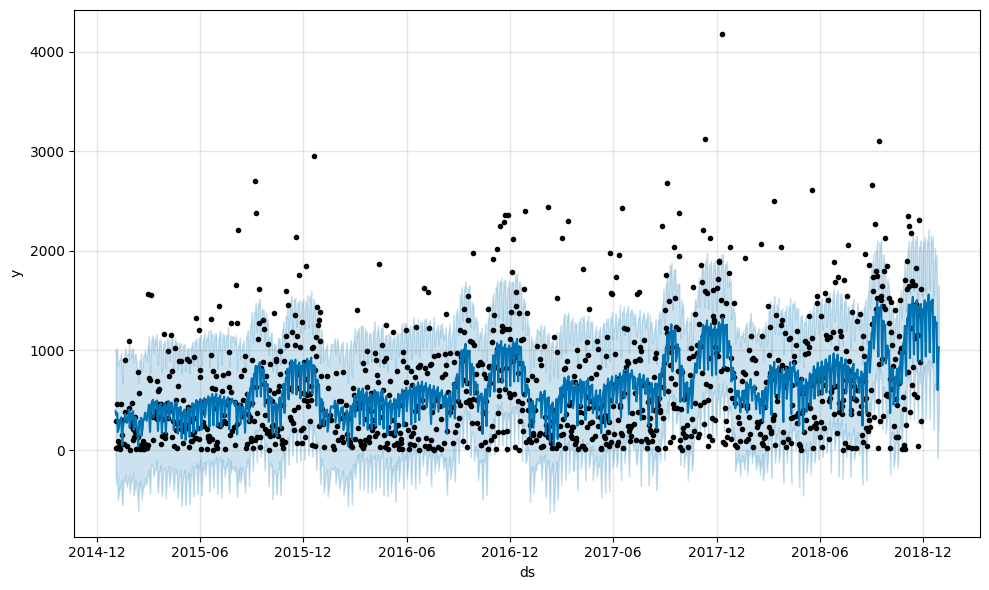

In [263]:
model.plot(forecast);

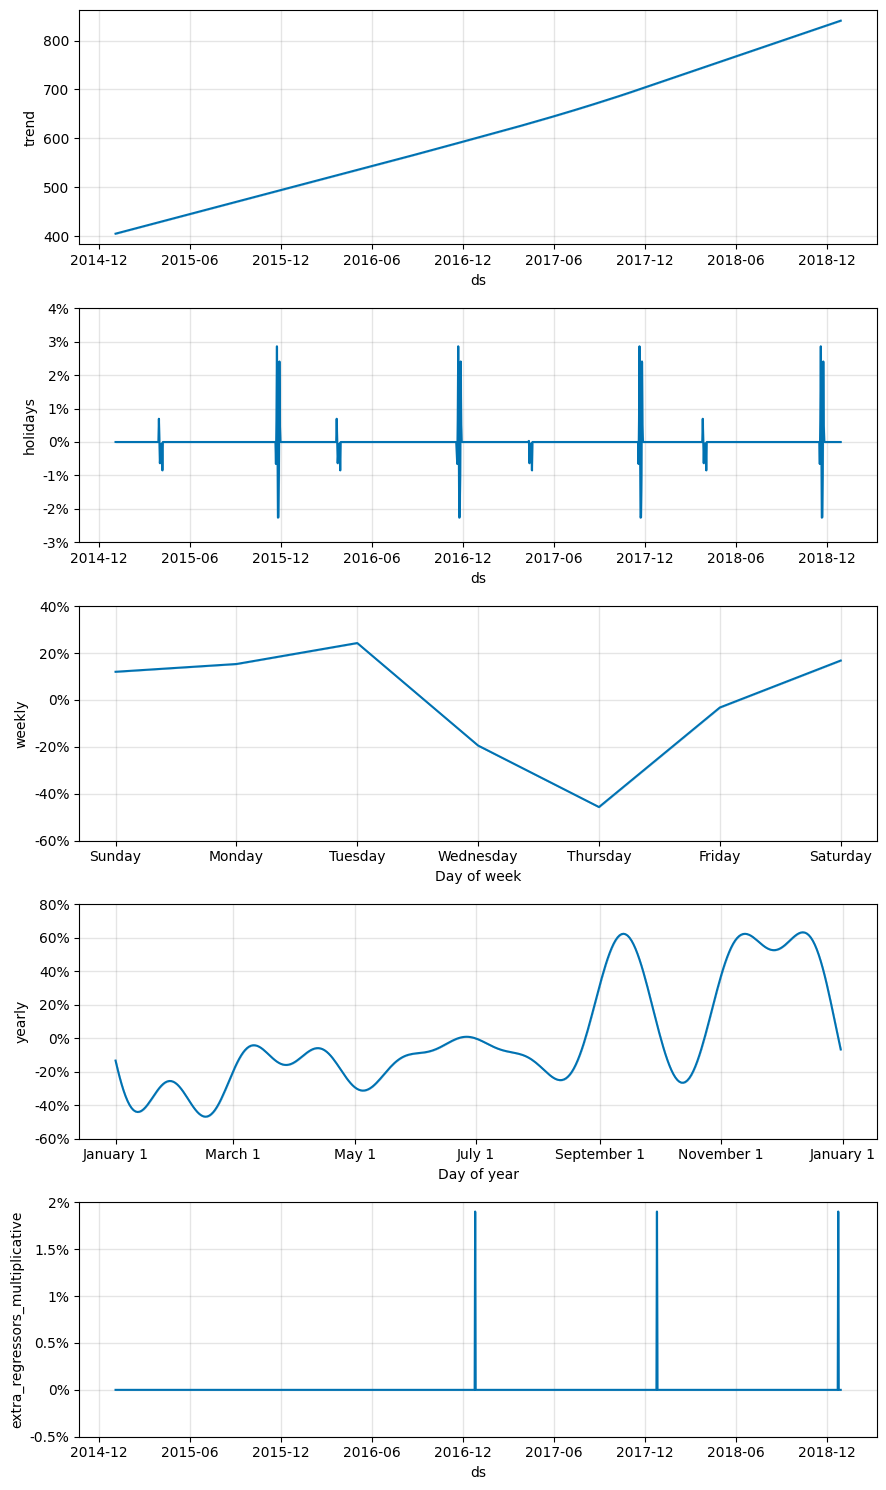

In [264]:
model.plot_components(forecast);

In [266]:
import pickle

# Assume `my_model` is a trained Prophet model
with open('my_model.pkl', 'wb') as f:
    pickle.dump(model, f)